Let's look at the characteristics of organizations winding down over time, possibly up to 6 months. We want to identify 2 scenarios:

1. Organizations that have wound down to a complete close, a properly defined churned client. These organizations have closed their account and migrated all processing to another vendor.
2. Organizations that have wound down processing, likely primarily one time, but have not closed their account and possibly continue to process recurring payments until expiration.

This analysis will require identifying organizations winding down processing in a significant way, not necessarily closed. We will look for organizations that peaked and rapidly fell, whether the bottom was $0 or not.

In [37]:
import pandas as pd
import numpy as np

import sys
sys.path.append("../../../../scripts/")
from s3_support import *

%matplotlib inline

# Load data

In [38]:
# query transactions grouped by month
q = '''select
                org,
                count(distinct form) as forms,
                date_trunc('quarter', date) as quarter,
                count(id) as count,
                sum(amount) as volume
            from transactions
                where status='A'
                group by org, date_trunc('quarter', date)
                order by date_trunc('quarter', date) desc;'''
trans = redshift_query_read(q)
# localize org statuses
orgs = redshift_query_read("select distinct(id), status from organization order by date desc", schema="production")

In [39]:
trans['quarter'] = pd.to_datetime(trans['quarter'])
trans = trans.sort_values('quarter', ascending=True)

In [40]:
# group trans by org and calculate exploratory stats on volume
agg = trans[trans['volume']>0].groupby('org')['volume'].agg({'max', 'mean', 'min', 'last', 'count', 'std'}).reset_index()
agg['max_last_diff'] = (agg['last'] - agg['max']) / agg['max']
agg['mean_last_diff'] = (agg['last'] - agg['mean']) / agg['mean']

# drop 0 org from agg
agg = agg[agg['org']!=0]
# join statuses
agg['status'] = agg['org'].apply(lambda x: orgs[orgs['id']==int(x)]['status'].iloc[0])

In [41]:
def get_perc_gt_mean(org):
    this_org_df = trans[trans['org']==org]
    this_mean = this_org_df[this_org_df['volume']>0]['volume'].mean()
    return float(len(this_org_df[this_org_df['volume']>this_mean])) / float(len(this_org_df))

agg['perc_gt_mean'] = agg['org'].apply(get_perc_gt_mean)

# Identify failing orgs

In [42]:
fallen_peak = agg[(agg['count']>4)&(agg['mean_last_diff']<-.75)&(agg['max']>5000.)].copy()

In [43]:
print("len all: {}; len > 4 quarters: {}".format(len(agg), len(agg[agg['count']>4])))
print("len last < 25% mean & vol > $5k: {}".format(len(fallen_peak)))
print("len filtering for 30% > mean: {}".format(len(fallen_peak[fallen_peak['perc_gt_mean']>.3])))
fallen_peak.head(3)

len all: 5145; len > 4 quarters: 3066
len last < 25% mean & vol > $5k: 1292
len filtering for 30% > mean: 917


,org,last,max,min,std,count,mean,max_last_diff,mean_last_diff,status,perc_gt_mean
1,6,3437.7,99549.22,665.75,20292.391600,48,16261.537708,-0.965467,-0.788599,1,0.326531
4,25,7675.0,116087.00,6684.00,32090.294670,15,37600.060000,-0.933886,-0.795878,0,0.263158
5,31,1637.0,35090.00,100.00,8598.491448,48,8832.040625,-0.953349,-0.814652,1,0.380000


Let's pick a few sample orgs to look at their processing trajectory. We ideally want to see a steady climb in processing and relatively steep dropoff so we want some idea of how many organizations meet this trend. I'm not yet sure how to measure that in aggregate so perhaps looking at some sample organizations' history will give me an idea.

_Update 1_: percentage difference between last and max values provides too much leeway to organizations that peak or perhaps have only one great quarter but otherwise trend in the same values, trying percentage difference between last and mean of -75%

_Update 2_: still seeing very peaky processing history, filtering for last being below more than 50% of observations be greater than mean

_Update 3_: 50% seemed too steep a filter leaving less than 150 organizations, decreasing this filter to 30%

         org  max_last_diff  mean_last_diff  perc_gt_mean
503      757      -0.994336       -0.980110      0.428571
773     1498      -0.955799       -0.778568      0.352941
985     8125      -0.995116       -0.978392      0.343750
1436   34789      -0.999951       -0.999861      0.500000
2048  380931      -0.966258       -0.871441      0.454545
2655  438437      -0.956062       -0.908007      0.461538
2941  441683      -0.980747       -0.954668      0.571429
3036  441861      -0.977334       -0.953331      0.545455
3262  442220      -0.957485       -0.894913      0.500000
3505  442581      -0.999767       -0.999226      0.333333
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.2;0.775x0.68)
AxesSubplot(0.125,0.2;0.775x0.68)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.2;0.775x0.68)
AxesSubplot(0.125,0.2;0.775x0.68)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


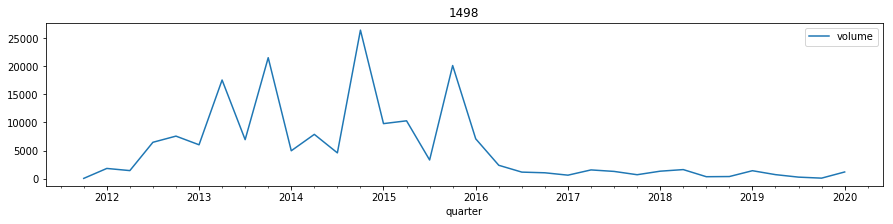

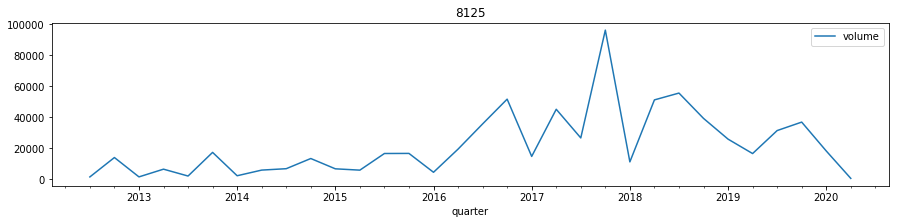

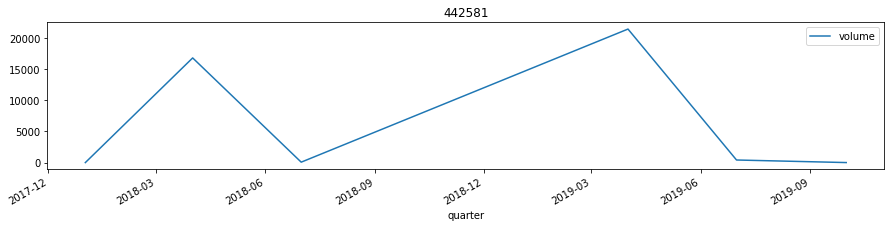

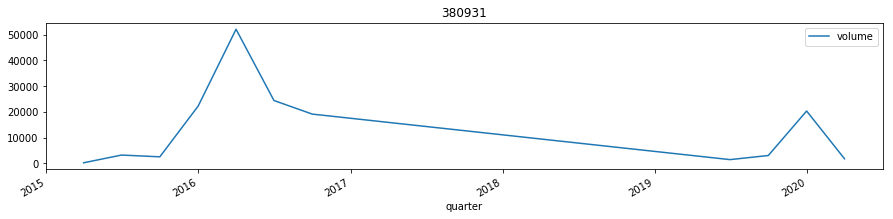

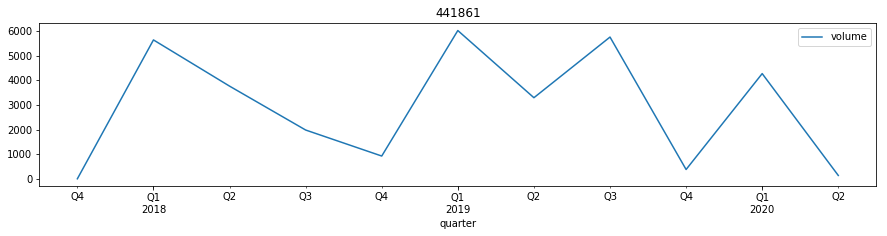

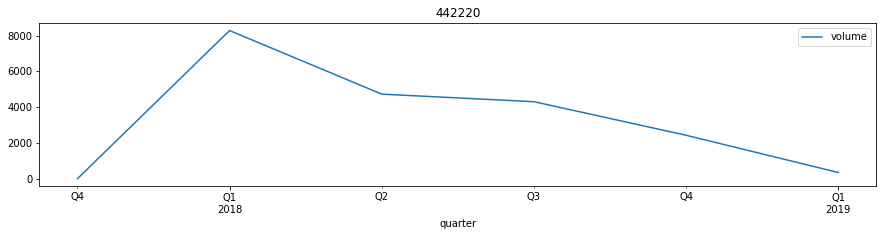

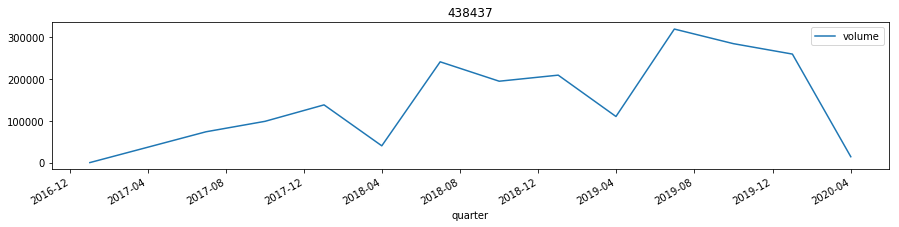

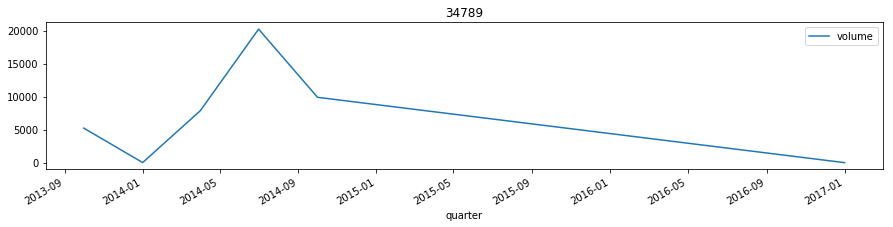

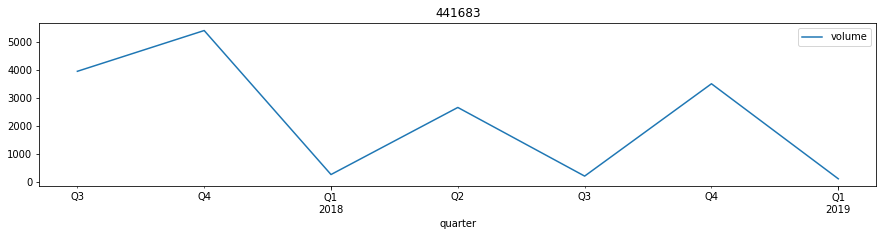

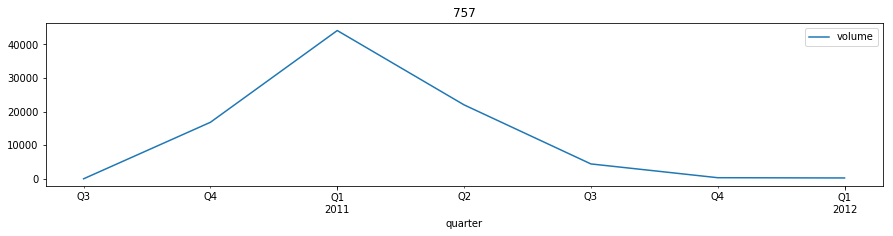

In [44]:
sample_orgs = fallen_peak[fallen_peak['perc_gt_mean']>.3].sample(10)['org'].tolist()

print(fallen_peak[fallen_peak['org'].isin(sample_orgs)][['org', 'max_last_diff', 'mean_last_diff', 'perc_gt_mean']])
for o in sample_orgs:
    print(trans[trans['org']==o][['quarter', 'volume']].plot(title=str(o), x="quarter", y="volume", figsize=(15,3)))

These filters are looking much more promising as generally leading to the processing trends we would like to identify. The final counts are as follows:

- 5146: all
- 3067: > 4 quarters of observations with > \$0 processing
- 1292: last < 25% mean & vol > \$5k
- 917: len filtering for 30% > mean

The filters leave us with approximately 20% of organizations. That's still a rather high segment of organizations but this is not yet accounting for status (ie, we have not looked at organization status here). Judging from the sample organizations who's processing history is visualized above, it does appear to approximate the trend we would like to identify. 

Regardless of whether or not these organizations prove to be useful for churn prediction, these filters might be useful to CX in order to identify failing organizations.

# Examining closed orgs

It appears that the majority of falling organizations are currently active. Let's look at the trends for closed organizations to see how they reflect the intial wind down hypothesis.

Status values:

- 0: deleted
- 1: active
- 2: closed
- 3: suspended

In [45]:
print(len(fallen_peak[fallen_peak['perc_gt_mean']>.3]))
fallen_peak[fallen_peak['perc_gt_mean']>.3]['status'].value_counts()

917


1    689
2    148
0     77
3      3
Name: status, dtype: int64

In [46]:
closed_orgs = agg[(agg['status']==2)&(agg['count']>4)].copy()

len_all = len(agg)
len_closed = len(closed_orgs)
perc_closed = (float(len_closed) / float(len_all)) * 100.

print("{} closed orgs ({:.2f}%)".format(len_closed, perc_closed))

393 closed orgs (7.64%)


         org  max_last_diff  mean_last_diff  perc_gt_mean
489      735      -0.143103        1.281279      0.411765
547      835      -0.990360       -0.955768      0.312500
640     1005      -0.948846       -0.811336      0.272727
753     1405      -0.996351       -0.991128      0.470588
1066   13239      -0.986111       -0.967004      0.600000
1340   31749      -0.999964       -0.999903      0.375000
1523   39918      -0.928459       -0.847176      0.423077
1644   44023      -0.868277       -0.394306      0.272727
1862  196612      -0.566158       -0.084749      0.526316
2806  441434      -0.913043       -0.685864      0.333333
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.2;0.775x0.68)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.

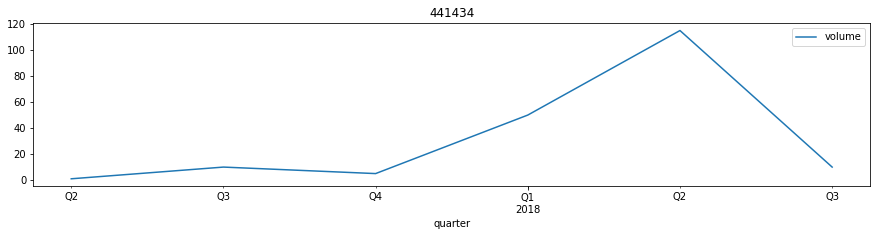

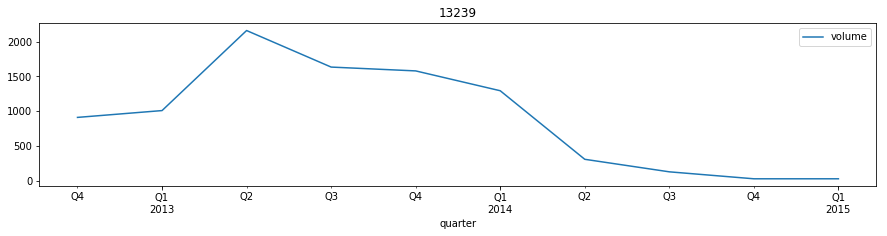

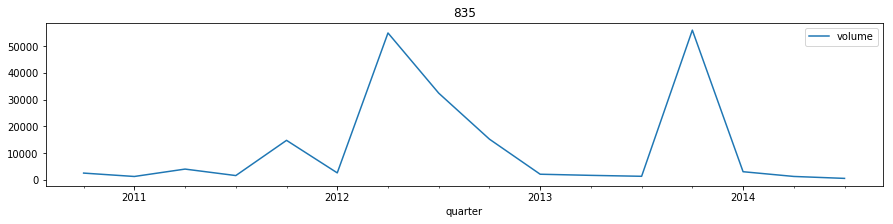

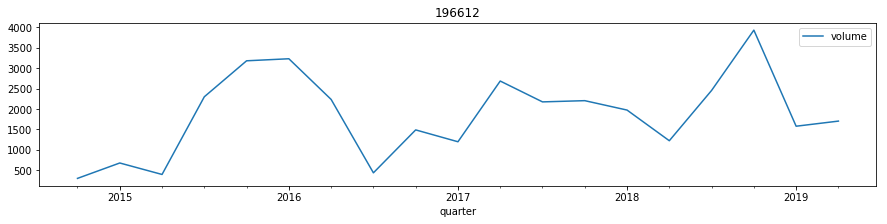

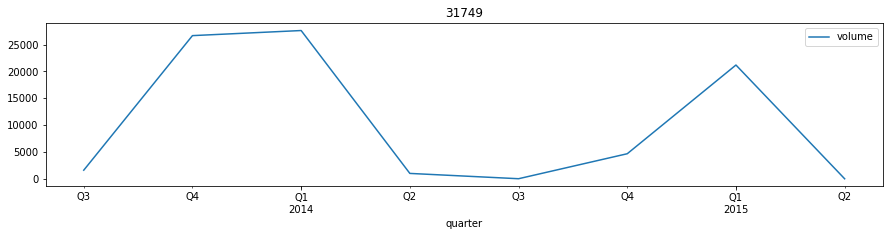

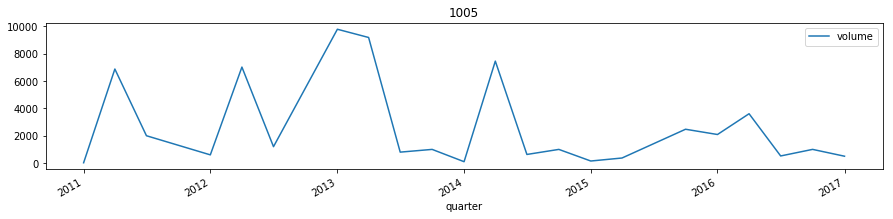

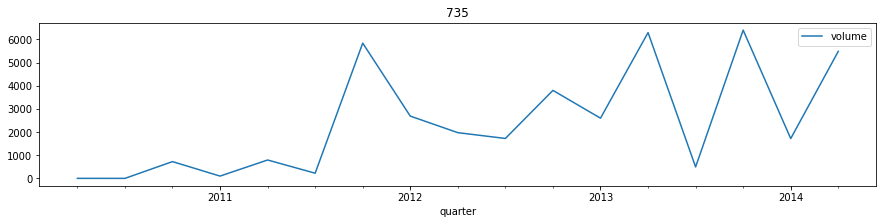

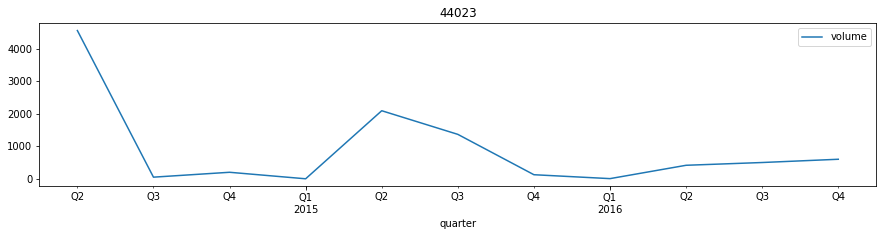

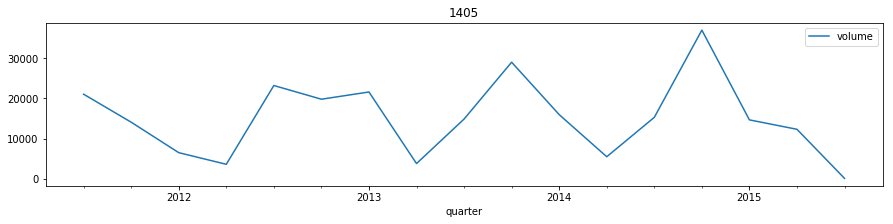

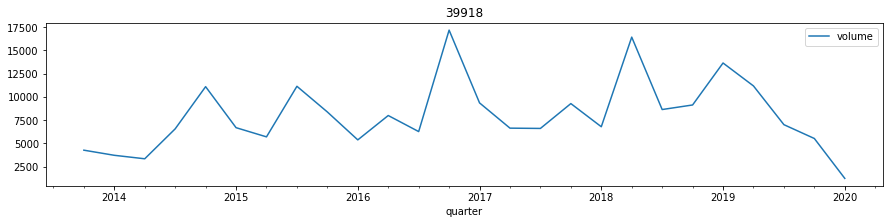

In [47]:
sample_orgs = closed_orgs.sample(10)['org'].tolist()

print(closed_orgs[closed_orgs['org'].isin(sample_orgs)][['org', 'max_last_diff', 'mean_last_diff', 'perc_gt_mean']])
for o in sample_orgs:
    print(trans[trans['org']==o][['quarter', 'volume']].plot(title=str(o), x="quarter", y="volume", figsize=(15,3)))

In [48]:
agg.groupby('status')['perc_gt_mean'].mean()

status
0    0.338750
1    0.343350
2    0.348316
3    0.283423
4    0.000000
8    0.353846
9    0.277778
Name: perc_gt_mean, dtype: float64

It doesn't appear that closed organizations trend downward over their lifetime much more than active organizations. This could be due to the large proportion of active organizations that are also not growing. _It might prove productive to categorize organizations by their growth patterns in order to separate the thriving organizations from those that are not thriving._

# Clustering by volume standard deviation

In [50]:
agg['std'].min(), agg['std'].max(), agg['std'].mean()

(0.0, 1758747.51400706, 11776.800377799404)